In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


In [2]:
data_path="/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv"

df=pd.read_csv(data_path)

In [3]:
df.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2026-02-24 15:42:48.550359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771947768.856139      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771947768.952111      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771947769.698267      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771947769.698338      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771947769.698342      17 computation_placer.cc:177] computation placer alr

In [5]:
df["Review Text"] = df["Review Text"].fillna("")
texts = df["Review Text"]

In [6]:
texts=df["Review Text"].tolist()
labels=df["Rating"].tolist()

In [7]:
vacob_size=20000
tokenizer=Tokenizer(num_words=vacob_size,oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)

max_len=50

x=pad_sequences(sequences,maxlen=max_len,padding="post",truncating="post")
y=tf.convert_to_tensor(labels)

2026-02-24 15:43:26.888555: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
print(x.shape)
print(y.shape)

(23486, 50)
(23486,)


In [9]:
#values to be entered into the score

inputs=tf.keras.Input(shape=(max_len,))

x_embed=tf.keras.layers.Embedding(
    input_dim=vacob_size,
    output_dim=8
)(inputs)

In [10]:
import keras.ops as ops

In [11]:
embed_dim=8

Wq=tf.Variable(tf.random.normal((embed_dim,embed_dim)))
Wk=tf.Variable(tf.random.normal((embed_dim,embed_dim)))
Wv=tf.Variable(tf.random.normal((embed_dim,embed_dim)))

Q=tf.keras.layers.Dense(embed_dim)(x_embed)
K=tf.keras.layers.Dense(embed_dim)(x_embed)
V=tf.keras.layers.Dense(embed_dim)(x_embed)

#Attention(Q,K,V)=softmax(Score)V
score=tf.keras.layers.Lambda(
 lambda x: tf.matmul(x[0], x[1], transpose_b=True) / tf.math.sqrt(tf.cast(embed_dim, tf.float32)))([Q, K])
weight = ops.softmax(score, axis=-1)

context=ops.matmul(weight,V)

In [12]:
W1 = tf.Variable(tf.random.normal((embed_dim, 32)))
b1 = tf.Variable(tf.zeros(32))

W2 = tf.Variable(tf.random.normal((32, embed_dim)))
b2 = tf.Variable(tf.zeros(embed_dim))
ff_out = tf.keras.layers.Dense(32, activation='relu')(context)
ff_out = tf.keras.layers.Dense(embed_dim)(ff_out)

In [13]:
output = tf.keras.layers.Add()([context, ff_out])

In [14]:
pooled = tf.keras.layers.GlobalAveragePooling1D()(output)  #avarage pooling

logits = tf.keras.layers.Dense(1, activation='sigmoid')(pooled)

In [15]:
model = tf.keras.Model(inputs=inputs, outputs=logits)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']
)
model.fit(x, y, batch_size=128, epochs=3, validation_split=0.1)

Epoch 1/3
166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0348 - loss: -139.0863 - val_accuracy: 0.0341 - val_loss: -3850.3389
Epoch 2/3
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0348 - loss: -16632.8379 - val_accuracy: 0.0341 - val_loss: -140231.9375
Epoch 3/3
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0351 - loss: -295424.1562 - val_accuracy: 0.0341 - val_loss: -1235046.0000


In [16]:
#Example 

In [17]:
sample_text = ["I usually wear size L and this dress fit me perfectly."] 
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_pad = pad_sequences(sample_seq, maxlen=max_len, padding="post", truncating="post")

In [18]:
pred = model.predict(sample_pad)
if pred[0][0] > 0.5:
    print("Review Result: Recommended")
else:
    print("Review Result: Not Recommended")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Review Result: Recommended


In [19]:
import matplotlib.pyplot as plt

In [20]:
grouped = df.groupby(["Class Name", "Recommended IND"]).size().unstack(fill_value=0)

if 0 not in grouped.columns:
    grouped[0] = 0
if 1 not in grouped.columns:
    grouped[1] = 0

grouped = grouped.sort_values(by=1, ascending=False)

<Figure size 640x480 with 0 Axes>

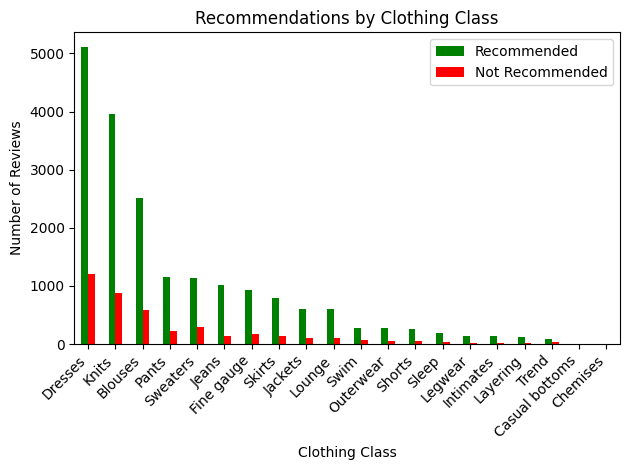

In [21]:
plt.figure()

grouped[[1, 0]].plot(
    kind="bar",
    color=["green", "red"]   # İSTEDİĞİN RENKLER ✅
)

plt.xlabel("Clothing Class")
plt.ylabel("Number of Reviews")
plt.title("Recommendations by Clothing Class")
plt.legend(["Recommended", "Not Recommended"])

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()